# Brazil Sao Paulo sugarcane crop model using Gro API
In this notebook, we walk through the process of building a simple "crop model" using data in Gro. The accompanying Gro web app display for [Sao Paulo Sugarcane](https://app.gro-intelligence.com/displays/wZRlYJQ9B) provides an overview of the data series we will use. The crop model we will create is a very basic  model that uses crop-production-weighted NDVI to forecast  yield.

## Preliminary
Here we use a `CropModel` object as well as some feature transformation functions. We also save the entity ids for the `item` [sugarcane](https://app.gro-intelligence.com/dictionary/items/538), `metric` [processing yield](https://app.gro-intelligence.com/dictionary/metrics/6881050), and for the `region` [Sao Paulo](https://app.gro-intelligence.com/dictionary/regions/10408).  We will use these throughout the notebook to simplify the retrieval, storage and manipulation of data.

In [269]:
import os
import numpy as np
import pandas as pd
import itertools
from datetime import datetime

from api.client.crop_model import CropModel
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
import statsmodels.api as sm
from sklearn.cluster import KMeans

model = CropModel('api.gro-intelligence.com', os.environ['GROAPI_TOKEN'])
country_id = model.search_for_entity('regions', "brazil")
region_id = model.search_for_entity('regions', "Sao Paulo")
crop_id =  model.search_for_entity('items', "sugarcane, TRS")


##  Historical Sugar Processing yields
To get data series for the province level sugarcane yield for Sao Paulo, we set the entities (item, metric and region), and get the available data series.  The <em>source</em> for Sao Paulo sugarcane yields is [UNICA](https://app.gro-intelligence.com/dictionary/sources/47).

In [270]:
yield_entities = {}
yield_entities['item_id']  = crop_id
yield_entities['region_id'] = region_id
yield_entities['metric_id'] = model.search_for_entity('metrics', "processing yield mass/mass")
yield_entities['source_id'] = 47 # unica
data_series_list = model.get_data_series(**yield_entities)
print("There are {} data series for {}.".format(len(data_series_list), yield_entities))
for data_series in data_series_list:
    print("source_id {}: {} to {}".format(
        data_series['source_id'], data_series['start_date'], data_series['end_date']))
    model.add_single_data_series(data_series)

Added {u'end_date': u'2018-03-31T00:00:00.000Z', u'source_name': u'UNICA', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Sugarcane, TRS', u'partner_region_name': u'World', u'frequency_id': 9, u'source_id': 47, u'partner_region_id': 0, u'item_id': 7539, u'metric_name': u'Processing Yield (mass/mass)', u'start_date': u'2007-04-01T00:00:00.000Z', u'metric_id': 6881050}
INFO:api.client.lib:Added {u'end_date': u'2018-03-31T00:00:00.000Z', u'source_name': u'UNICA', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Sugarcane, TRS', u'partner_region_name': u'World', u'frequency_id': 9, u'source_id': 47, u'partner_region_id': 0, u'item_id': 7539, u'metric_name': u'Processing Yield (mass/mass)', u'start_date': u'2007-04-01T00:00:00.000Z', u'metric_id': 6881050}
Added {u'end_date': u'2019-06-30T00:00:00.000Z', u'source_name': u'UNICA', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Sugarcane, TRS', u'partner_region_name': u'World'

There are 2 data series for {'item_id': 7539, 'source_id': 47, 'region_id': 10408, 'metric_id': 6881050}.
source_id 47: 2007-04-01T00:00:00.000Z to 2018-03-31T00:00:00.000Z
source_id 47: 2008-04-01T00:00:00.000Z to 2019-06-30T00:00:00.000Z


* As printed above, there are 2 available data series for the Sugar processing yield of Sao Paulo
* Next we retrive the data frame of those series and make sure to subset subset to the metric and region we need

In [274]:

df = model.get_df()
yield_df = df.loc[(df.metric_id == yield_entities['metric_id']) & \
                  (df.region_id == yield_entities['region_id'])]
yield_df.end_date = pd.to_datetime(yield_df.end_date, utc=True)
yield_df['DOY']  = yield_df.end_date.apply(lambda x: int(x.strftime('%j')))
yield_df['Year'] = yield_df.end_date.apply(lambda x: x.year)
yield_df.sort_values(['Year', 'DOY']).tail()



,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,reporting_date,start_date,unit_id,value,DOY,Year
214,2019-04-30 00:00:00+00:00,23,866,1,7539,6881050,10408,None,2019-04-16T00:00:00.000Z,866,99.754063,120,2019
215,2019-05-15 00:00:00+00:00,23,866,1,7539,6881050,10408,None,2019-05-01T00:00:00.000Z,866,108.653547,135,2019
216,2019-05-31 00:00:00+00:00,23,866,1,7539,6881050,10408,None,2019-05-16T00:00:00.000Z,866,114.160160,151,2019
217,2019-06-15 00:00:00+00:00,23,866,1,7539,6881050,10408,None,2019-06-01T00:00:00.000Z,866,117.480458,166,2019
218,2019-06-30 00:00:00+00:00,23,866,1,7539,6881050,10408,None,2019-06-16T00:00:00.000Z,866,122.388328,181,2019


* The resulting data frame includes information on the start and end date of the periods corresponding to each processing yield observation, and ids representing the frequency, unit, unit scale, item, metric, and region of our Gro data series. 
* The Day of Year and Year columns are derived from the end_date column to help with feature transformation processing

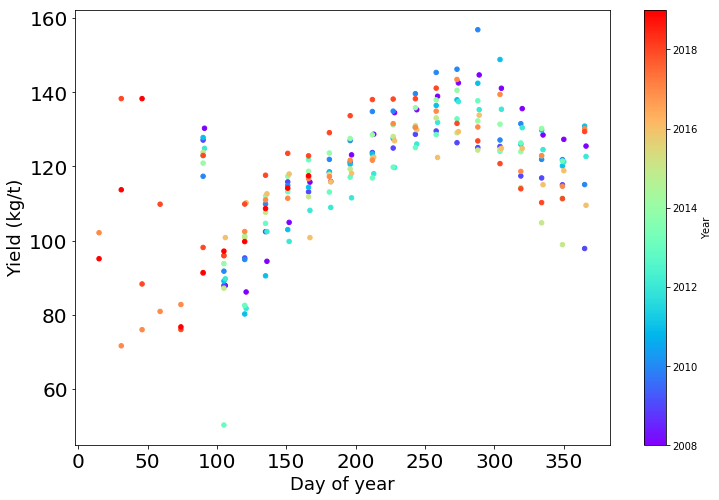

In [5]:
fig, axes = plt.subplots(1, 1)
yield_df[yield_df['value']<300].plot(x='DOY', y='value', kind='scatter',c='Year', cmap='rainbow',
                      ax=axes, figsize=(12,8), fontsize=20, legend=True)
plt.xlabel("Day of year", fontsize=18)
plt.ylabel("Yield (kg/t)", fontsize=18)
plt.show()

* As we can see in this figure above, the sugar processing yield follows a nice increasing pattern from the Day of year (DOY) 100 to about 270 and then goes back down 
* The processing yield between the DOY 350 and 100 appear to show no pattern, and there are only data points for recent years
* For the purpose of this analysis, we thus exclude the study period to between the DOY 100 and 350

In [275]:
df_within_range = yield_df[(yield_df['DOY'] > 100) & (yield_df['DOY'] < 350)]

* In case of making forecast of a next period of ATR, we would generate another dataframe the new dates. For example, here we add 2019-07-15 as a date to be predicted.

In [ ]:
unknown_df = df_within_range.set_index('end_date').reindex(
                                [pd.to_datetime('2019-07-15')]
                             ).reset_index()
unknown_df['DOY']  = unknown_df.end_date.apply(lambda x: int(x.strftime('%j')))
unknown_df['Year'] = unknown_df.end_date.apply(lambda x: x.year)
df_within_range = pd.concat([df_within_range, unknown_df
                             ], ignore_index=True)


* Make sure that the end_date column is converted to datetime and the DOY, Year columns are integers

In [260]:
df_within_range['end_date'] = pd.to_datetime(df_within_range['end_date'], utc=True)
df_within_range.DOY = df_within_range.DOY.astype(int)
df_within_range.Year = df_within_range.Year.astype(int)
df_within_range.rename(columns={'value': 'ATR'}, inplace=True)


## NDVI of Sao Paulo
The main signal we will use to model crop yields is [NDVI](https://app.gro-intelligence.com/dictionary/items/321), which represents vegetation biomass per pixel, and thus is a good physical proxy for yield (production mass per unit of area).

First we load the historical data for province level NDVI.  Here, there  are actually two data series for each region, one with `8-day` and one with `16-day` periods. We choose to use the series with 8-day (frequency_id = 3).

In [5]:
entities = {}
entities['item_id'] =  model.search_for_entity('items', "Vegetation NDVI")
entities['metric_id'] = model.search_for_entity('metrics', "Vegetation Indices index")
entities['frequency_id'] = 3


entities['region_id'] = region_id
for data_series in model.get_data_series(**entities):
    model.add_single_data_series(data_series)

Added {u'end_date': u'2019-07-03T00:00:00.000Z', u'source_name': u'GIMMS MODIS NDVI', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Vegetation (NDVI)', u'partner_region_name': u'World', u'frequency_id': 3, u'source_id': 3, u'partner_region_id': 0, u'item_id': 321, u'metric_name': u'Vegetation Indices', u'start_date': u'2000-02-18T00:00:00.000Z', u'metric_id': 70029}


In [28]:
df = model.get_df()
raw_ndvi = df[(df['item_id'] == entities['item_id']) & (df['metric_id']==entities['metric_id'])]
raw_ndvi.head()


,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,start_date,unit_id,value
0,2000-02-25 00:00:00+00:00,3,189,1,321,70029,10408,2000-02-18T00:00:00.000Z,189,0.762697
1,2000-03-04 00:00:00+00:00,3,189,1,321,70029,10408,2000-02-26T00:00:00.000Z,189,0.695848
2,2000-03-12 00:00:00+00:00,3,189,1,321,70029,10408,2000-03-05T00:00:00.000Z,189,0.691231
3,2000-03-20 00:00:00+00:00,3,189,1,321,70029,10408,2000-03-13T00:00:00.000Z,189,0.687999
4,2000-03-28 00:00:00+00:00,3,189,1,321,70029,10408,2000-03-21T00:00:00.000Z,189,0.712319


In [29]:
raw_ndvi.describe()

,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,unit_id,value
count,884.0,884.0,884.0,884.0,884.0,884.0,884.0,884.000000
mean,3.0,189.0,1.0,321.0,70029.0,10408.0,189.0,0.630422
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.079012
min,3.0,189.0,1.0,321.0,70029.0,10408.0,189.0,0.386523
25%,3.0,189.0,1.0,321.0,70029.0,10408.0,189.0,0.568329
50%,3.0,189.0,1.0,321.0,70029.0,10408.0,189.0,0.650462
75%,3.0,189.0,1.0,321.0,70029.0,10408.0,189.0,0.698384
max,3.0,189.0,1.0,321.0,70029.0,10408.0,189.0,0.762697


* The start and end dates of individual NDVI periods do not match with that of the Sugar processing yield periods
* In order to synchronize those two data series, we shall transform the NDVI data to a daily time step first and then pick the NDVI value that corresponds to the sugar processing yield data periods' end dates

In [31]:
# transform the 8-day data into a daily dataframe
date_index = 'end_date'
startday = 100
endday = 350
region_index='region_id'
feature = 'value'
raw_ndvi[date_index] = pd.to_datetime(raw_ndvi[date_index], utc=True)
min_date = raw_ndvi[date_index].min()
max_date = pd.to_datetime("{}-{}".format(raw_ndvi[date_index].max().year, endday), 
                          format='%Y-%j', utc=True)
date_range = pd.date_range(min_date, max_date, freq='D', name=date_index)
raw_ndvi_pivot = raw_ndvi.pivot_table(index=date_index, columns=region_index, values=feature)

raw_ndvi_filled = raw_ndvi_pivot.reset_index().set_index(date_index).reindex(
    date_range).asfreq('D').interpolate(
    method='linear',limit_direction='forward', axis=0).stack(   
    region_index).reset_index(name=feature)
raw_ndvi_filled.describe()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,region_id,value
count,7235.0,7235.000000
mean,10408.0,0.630343
std,0.0,0.077455
min,10408.0,0.386523
25%,10408.0,0.570576
50%,10408.0,0.645618
75%,10408.0,0.697275
max,10408.0,0.762697


* The data frame printed above shows the result of applying linear interpolation of NDVI from 8-day periods to daily timestep
* Next, subset the NDVI data to our study timeframe between the DOY 100 and 350

In [32]:
# Get the Doy of year (DOY) as well as Year from the date index
raw_ndvi_filled.loc[:, 'doy'] = raw_ndvi_filled[date_index].dt.dayofyear
raw_ndvi_filled.loc[:, 'year'] = raw_ndvi_filled[date_index].dt.year
ndvi_within_range = raw_ndvi_filled[(raw_ndvi_filled['doy'] > 100) & (
    raw_ndvi_filled['doy'] < 350)]
ndvi_within_range.describe()

,region_id,value,doy,year
count,4980.0,4980.000000,4980.000000,4980.00000
mean,10408.0,0.596793,225.000000,2009.50000
std,0.0,0.069556,71.886747,5.76686
min,10408.0,0.386523,101.000000,2000.00000
25%,10408.0,0.536131,163.000000,2004.75000
50%,10408.0,0.603312,225.000000,2009.50000
75%,10408.0,0.652549,287.000000,2014.25000
max,10408.0,0.730112,349.000000,2019.00000


* And then merge together the NDVI data frame with the ATR or sugar processing yield data frame
* keep the NDVI values of the dates that match with the ATR period end dates

In [33]:
ndvi_within_range.rename(columns={'value': 'ndvi'}, inplace=True)
ndvi_df = ndvi_within_range[ndvi_within_range['year'].isin(df_within_range['Year'].unique())]


In [282]:
ndvi_df.loc[:, 'DOY'] = ndvi_df.doy.astype(int)
ndvi_df.loc[:, 'Year'] = ndvi_df.year.astype(int)

ndvi_y = df_within_range[['DOY','Year','ATR']].merge(ndvi_df[['end_date','doy','year', 'ndvi']],
                        left_on=['DOY','Year'], right_on= ['doy','year'], how='left')
ndvi_y.tail()


,DOY,Year,ATR,end_date,doy,year,ndvi
185,120,2019,99.754063,2019-04-30 00:00:00+00:00,120,2019,0.715064
186,135,2019,108.653547,2019-05-15 00:00:00+00:00,135,2019,0.714196
187,151,2019,114.160160,2019-05-31 00:00:00+00:00,151,2019,0.695092
188,166,2019,117.480458,2019-06-15 00:00:00+00:00,166,2019,0.670779
189,181,2019,122.388328,2019-06-30 00:00:00+00:00,181,2019,0.637306


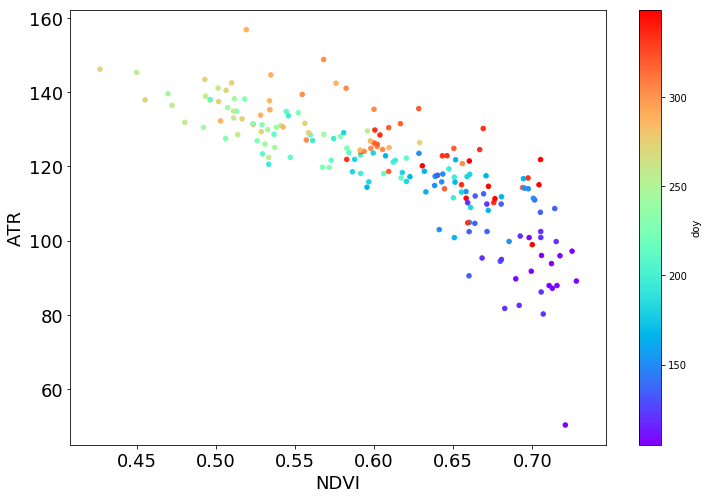

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))
        
ndvi_y.plot(x='ndvi', y='ATR', c='doy', cmap='rainbow', kind='scatter', ax=ax, fontsize=18)
plt.xlabel('NDVI', fontsize=18)
plt.ylabel('ATR', fontsize=18)
plt.show()

* As shown in this figure above, there is an overall negative relationship between the Sugar processing yield (ATR) and the NDVI values
* This negative correlation has greater magnitude (a steeper slope) during earlier DOY than the rest of the year

### Daily FEWS_PET versus Sugar Content
In addition to NDVI, there are various weather condition features that may be able to capture variation in the sugar processing yield. The potential evapotranspiration is one important measurement: [FEWS_PET](https://app.gro-intelligence.com/dictionary/items/5072)

In [36]:
entities = {}
entities['item_id'] =  5072
entities['metric_id'] = 4660031
entities['frequency_id'] = 1 # daily
entities['source_id'] = 44
entities['region_id'] = region_id

for data_series in model.get_data_series(**entities):
    model.add_single_data_series(data_series)


Added {u'end_date': u'2019-07-06T00:00:00.000Z', u'source_name': u'FEWS PET', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Potential evapotranspiration (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 44, u'partner_region_id': 0, u'item_id': 5072, u'metric_name': u'Evapotranspiration Value', u'start_date': u'2008-01-01T00:00:00.000Z', u'metric_id': 4660031}


In [37]:
model.get_df()
raw_pet = model._data_frame[model._data_frame['metric_id'] == 4660031]
raw_pet.tail()


,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,start_date,unit_id,value
4200,2019-07-02T00:00:00.000Z,1,2,1,5072,4660031,10408,2019-07-02T00:00:00.000Z,2,3.001716
4201,2019-07-03T00:00:00.000Z,1,2,1,5072,4660031,10408,2019-07-03T00:00:00.000Z,2,3.179158
4202,2019-07-04T00:00:00.000Z,1,2,1,5072,4660031,10408,2019-07-04T00:00:00.000Z,2,1.095079
4203,2019-07-05T00:00:00.000Z,1,2,1,5072,4660031,10408,2019-07-05T00:00:00.000Z,2,1.177512
4204,2019-07-06T00:00:00.000Z,1,2,1,5072,4660031,10408,2019-07-06T00:00:00.000Z,2,2.022430


In [39]:
raw_pet.loc[:, date_index] = pd.to_datetime(raw_pet[date_index], utc=True)

raw_pet.loc[:, 'doy'] = raw_pet[date_index].dt.dayofyear
raw_pet.loc[:, 'year'] = raw_pet[date_index].dt.year


* Since PET is available at daily time step, we could directly aggregate it to match with the same periods of the Sugar processing yield or ATR dataset
* First merge the DOY information from the ATR dataset and then aggregate PET to those periods

In [223]:
raw_pet.tail()

,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,start_date,unit_id,value,doy,year
4200,2019-07-02 00:00:00+00:00,1,2,1,5072,4660031,10408,2019-07-02T00:00:00.000Z,2,3.001716,183,2019
4201,2019-07-03 00:00:00+00:00,1,2,1,5072,4660031,10408,2019-07-03T00:00:00.000Z,2,3.179158,184,2019
4202,2019-07-04 00:00:00+00:00,1,2,1,5072,4660031,10408,2019-07-04T00:00:00.000Z,2,1.095079,185,2019
4203,2019-07-05 00:00:00+00:00,1,2,1,5072,4660031,10408,2019-07-05T00:00:00.000Z,2,1.177512,186,2019
4204,2019-07-06 00:00:00+00:00,1,2,1,5072,4660031,10408,2019-07-06T00:00:00.000Z,2,2.022430,187,2019


In [284]:
pet_agg = raw_pet[['doy','year', 'value']].merge(df_within_range[['DOY','Year','ATR']],
                        right_on=['DOY','Year'], left_on= ['doy','year'], how='left')
pet_agg = pet_agg[pet_agg['year'] >= 2008][pet_agg['doy']>=100][pet_agg['doy']<=350]
pet_grouped = pet_agg.fillna(method='bfill').groupby(['year','DOY']).mean().reset_index()

pet_y = df_within_range.merge(pet_grouped[['DOY', 'value', 'year']], 
                               left_on=['DOY','Year'], right_on=['DOY', 'year'], how='left')
pet_y.sort_values(['Year','DOY']).tail()

,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,reporting_date,start_date,unit_id,ATR,DOY,Year,value,year
185,2019-04-30 00:00:00+00:00,23,866,1,7539,6881050,10408,None,2019-04-16T00:00:00.000Z,866,99.754063,120,2019,3.650152,2019
186,2019-05-15 00:00:00+00:00,23,866,1,7539,6881050,10408,None,2019-05-01T00:00:00.000Z,866,108.653547,135,2019,2.991520,2019
187,2019-05-31 00:00:00+00:00,23,866,1,7539,6881050,10408,None,2019-05-16T00:00:00.000Z,866,114.160160,151,2019,2.539245,2019
188,2019-06-15 00:00:00+00:00,23,866,1,7539,6881050,10408,None,2019-06-01T00:00:00.000Z,866,117.480458,166,2019,2.442303,2019
189,2019-06-30 00:00:00+00:00,23,866,1,7539,6881050,10408,None,2019-06-16T00:00:00.000Z,866,122.388328,181,2019,2.680475,2019


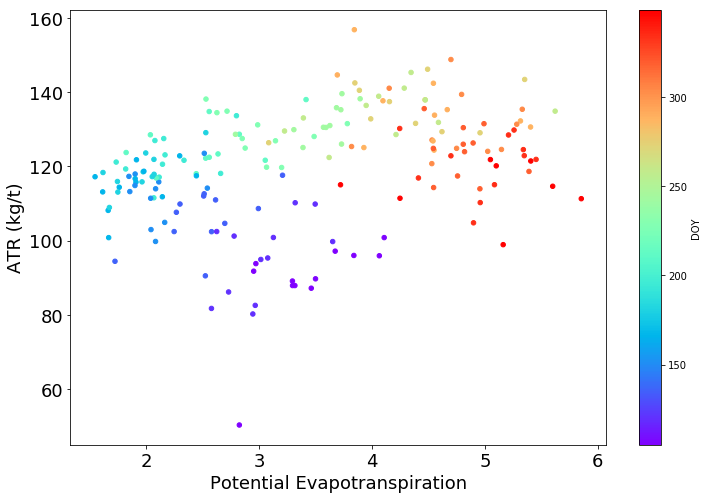

In [41]:
fig, ax = plt.subplots(figsize=(12, 8))
        
pet_y.plot(x='value', y='ATR', c='DOY', cmap='rainbow', kind='scatter', ax=ax, fontsize=18)
plt.xlabel('Potential Evapotranspiration', fontsize=18)
plt.ylabel('ATR (kg/t)', fontsize=18)
plt.show()


* There appears to be a positive relationship between ATR and PET for the DOY between 170 to 260, 
* While the rest of the days of a year appeared to show a much weaker relationship

### Daily TRMM precipitation versus Sugar Content
The daily precipitation is another weather variable that might be important to the sugar processing yield.
[TRMM](https://app.gro-intelligence.com/dictionary/sources/35)
[Precipitation](https://app.gro-intelligence.com/dictionary/items/10081)

In [48]:
entities = {}
entities['item_id'] =  10081
entities['metric_id'] = 2100031
entities['frequency_id'] = 1 # daily
entities['source_id'] = 35
entities['region_id'] = region_id

for data_series in model.get_data_series(**entities):
    if data_series['region_id']==region_id:
        model.add_single_data_series(data_series)


Added {u'end_date': u'2019-07-06T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Rainfall (modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2039, u'metric_name': u'Precipitation Quantity', u'start_date': u'2000-03-01T00:00:00.000Z', u'metric_id': 2100031}
Added {u'end_date': u'2011-12-31T00:00:00.000Z', u'source_name': u'TRMM 3B42RT', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Rainfall (modeled) 10-yr mean (2001-2010)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 35, u'partner_region_id': 0, u'item_id': 2046, u'metric_name': u'Precipitation Quantity', u'start_date': u'2011-01-01T00:00:00.000Z', u'metric_id': 2100031}


In [51]:
model.get_df()
raw_trmm = model._data_frame[(model._data_frame['metric_id'] == 2100031) & (
    model._data_frame['item_id'] == 2039)]
raw_trmm[date_index] = pd.to_datetime(raw_trmm[date_index], utc=True)

raw_trmm.loc[:, 'doy'] = raw_trmm[date_index].dt.dayofyear
raw_trmm.loc[:, 'year'] = raw_trmm[date_index].dt.year

raw_trmm.describe()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,unit_id,value,doy,year
count,7067.0,7067.0,7067.0,7067.0,7067.0,7067.0,7067.0,7067.000000,7067.000000,7067.000000
mean,1.0,2.0,1.0,2039.0,2100031.0,10408.0,2.0,3.919630,182.069195,2009.340314
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.129500,104.908184,5.595535
min,1.0,2.0,1.0,2039.0,2100031.0,10408.0,2.0,0.000000,1.000000,2000.000000
25%,1.0,2.0,1.0,2039.0,2100031.0,10408.0,2.0,0.042581,92.000000,2004.500000
50%,1.0,2.0,1.0,2039.0,2100031.0,10408.0,2.0,0.826223,180.000000,2009.000000
75%,1.0,2.0,1.0,2039.0,2100031.0,10408.0,2.0,5.686071,273.000000,2014.000000
max,1.0,2.0,1.0,2039.0,2100031.0,10408.0,2.0,54.555632,366.000000,2019.000000


* Similar to PET, TRMM is also a data source at the daily timestep, so we follow a similar procedure to aggregate it to the same periods as the ATR dataset

In [231]:
trmm_agg = raw_trmm[['doy','year', 'value']].merge(df_within_range[['DOY','Year','ATR']],
                        right_on=['DOY','Year'], left_on= ['doy','year'], how='left')
trmm_agg = trmm_agg[trmm_agg['year'] >= 2008][trmm_agg['doy']>=100][trmm_agg['doy']<=350]


trmm_grouped = trmm_agg.fillna(method='bfill').groupby(['DOY','year']).mean().reset_index()

trmm_y = df_within_range.merge(trmm_grouped[['DOY', 'value', 'year']], 
                               left_on=['DOY','Year'], right_on=['DOY', 'year'], how='left')
trmm_y.tail()

,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,start_date,unit_id,ATR,DOY,Year,value,year
186,2019-05-15 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-05-01T00:00:00.000Z,866.0,108.653547,135,2019,2.659477,2019.0
187,2019-05-31 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-05-16T00:00:00.000Z,866.0,114.160160,151,2019,2.796357,2019.0
188,2019-06-15 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-06-01T00:00:00.000Z,866.0,117.480458,166,2019,1.293619,2019.0
189,2019-06-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181,2019,0.155427,2019.0
190,2019-07-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,196,2019,NaN,NaN


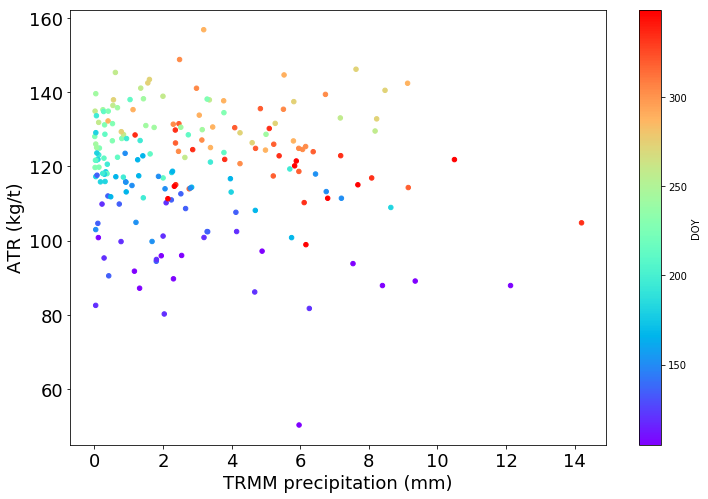

In [53]:
fig, ax = plt.subplots(figsize=(12, 8))
        
trmm_y.plot(x='value', y='ATR', c='DOY', cmap='rainbow', kind='scatter', ax=ax, fontsize=18)
plt.xlabel('TRMM precipitation (mm)', fontsize=18)
plt.ylabel('ATR (kg/t)', fontsize=18)
plt.show()


* As shown in the scatter plot above, there appears to be a mild negative relationship between ATR and TRMM precipitation post the DOY 300 and prior to the DOY 200

### Daily LST temperature versus Sugar Content
The Land Surface Temperature ([LST](https://app.gro-intelligence.com/dictionary/sources/26)) is a dailiy timestep temperature data source.


In [255]:
model = CropModel('api.gro-intelligence.com', os.environ['GROAPI_TOKEN'])
entities = {}
entities['item_id'] =  model.search_for_entity('items', "Land temperature")
entities['metric_id'] = model.search_for_entity('metrics', "Temperature")
entities['region_id'] = region_id
entities['frequency_id']= 1

model = CropModel('api.gro-intelligence.com', os.environ['GROAPI_TOKEN'])

for data_series in model.get_data_series(**entities):
    if data_series['region_id'] == region_id :
        model.add_single_data_series(data_series)


Added {u'end_date': u'2019-07-16T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}
INFO:api.client.lib:Added {u'end_date': u'2019-07-16T00:00:00.000Z', u'source_name': u'MOD11 LST', u'region_id': 10408, u'region_name': u'S\xe3o Paulo', u'item_name': u'Land temperature (daytime, modeled)', u'partner_region_name': u'World', u'frequency_id': 1, u'source_id': 26, u'partner_region_id': 0, u'item_id': 3457, u'metric_name': u'Temperature', u'start_date': u'2000-02-25T00:00:00.000Z', u'metric_id': 2540047}


* Again, we aggregate the LST temperature data to the same periods as the ATR sugar processing yield data

In [256]:
model.get_df()
raw_lst = model._data_frame[model._data_frame['metric_id'] == entities['metric_id']]
print(raw_lst.end_date.unique())
raw_lst.loc[:, date_index] = pd.to_datetime(raw_lst[date_index], utc=True)

raw_lst.loc[:, 'doy'] = raw_lst[date_index].dt.dayofyear
raw_lst.loc[:, 'year'] = raw_lst[date_index].dt.year

raw_lst.describe()

[u'2000-02-25T00:00:00.000Z' u'2000-02-26T00:00:00.000Z'
 u'2000-02-27T00:00:00.000Z' ... u'2019-07-14T00:00:00.000Z'
 u'2019-07-15T00:00:00.000Z' u'2019-07-16T00:00:00.000Z']


,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,unit_id,value,doy,year
count,6936.0,6936.0,6936.0,6936.0,6936.0,6936.0,6936.0,6884.000000,6936.000000,6936.000000
mean,1.0,36.0,1.0,3457.0,2540047.0,10408.0,36.0,26.820259,182.025375,2009.373414
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.356162,104.739457,5.588262
min,1.0,36.0,1.0,3457.0,2540047.0,10408.0,36.0,11.082408,1.000000,2000.000000
25%,1.0,36.0,1.0,3457.0,2540047.0,10408.0,36.0,23.958266,92.000000,2005.000000
50%,1.0,36.0,1.0,3457.0,2540047.0,10408.0,36.0,26.799027,181.000000,2009.000000
75%,1.0,36.0,1.0,3457.0,2540047.0,10408.0,36.0,29.807838,272.250000,2014.000000
max,1.0,36.0,1.0,3457.0,2540047.0,10408.0,36.0,42.230718,366.000000,2019.000000


In [267]:
lst_agg = raw_lst[['end_date','value', 'doy','year']].merge(df_within_range[['end_date','DOY']],
                        on='end_date' , how='left').drop_duplicates()
# lst_agg = raw_lst[['end_date','value', 'doy','year']].merge(df_within_range[['Year','DOY']],
#                         left_on=['doy','year'], right_on=['Year','DOY'] , how='left').drop_duplicates()
lst_agg = lst_agg[lst_agg['year'] >= 2008][lst_agg['doy']>=100][lst_agg['doy']<=350]


lst_grouped = lst_agg.fillna(method='bfill').groupby(['DOY','year']).mean().reset_index()
print(lst_grouped.head(10))

lst_y = df_within_range.merge(lst_grouped[['DOY', 'value', 'year']], 
                               left_on=['DOY','Year'], right_on=['DOY', 'year'], how='left')
lst_y.tail()

     DOY  year      value         doy
0  105.0  2008  30.340395  343.000000
1  105.0  2009  25.325962  137.857143
2  105.0  2010  25.456757  137.857143
3  105.0  2011  25.175455  102.500000
4  105.0  2012  27.930572  342.500000
5  105.0  2013  23.308656  137.857143
6  105.0  2014  24.099164  137.857143
7  105.0  2015  25.487776  102.500000
8  105.0  2016  26.496725  343.000000
9  105.0  2017  28.428144  143.833333


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,end_date,frequency_id,input_unit_id,input_unit_scale,item_id,metric_id,region_id,start_date,unit_id,ATR,DOY,Year,value,year
186,2019-05-15 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-05-01T00:00:00.000Z,866.0,108.653547,135,2019,25.375579,2019
187,2019-05-31 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-05-16T00:00:00.000Z,866.0,114.160160,151,2019,24.552704,2019
188,2019-06-15 00:00:00+00:00,23.0,866.0,1.0,7539.0,6881050.0,10408.0,2019-06-01T00:00:00.000Z,866.0,117.480458,166,2019,23.721730,2019
189,2019-06-30 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181,2019,25.639388,2019
190,2019-07-15 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,196,2019,22.033843,2019


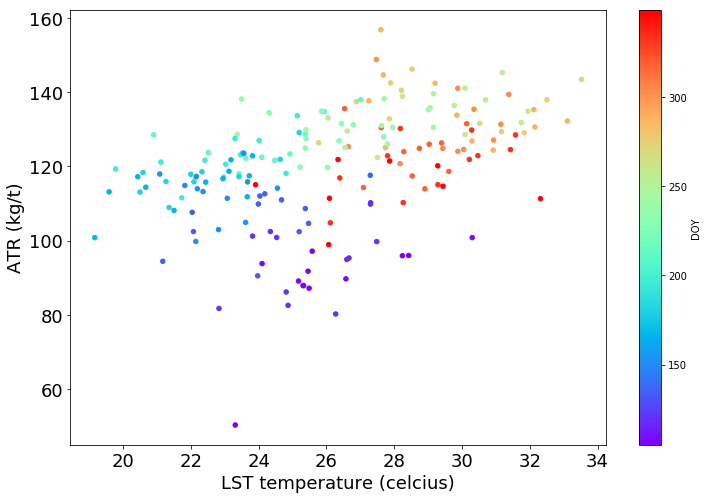

In [268]:
fig, ax = plt.subplots(figsize=(12, 8))
        
lst_y.plot(x='value', y='ATR', c='DOY', cmap='rainbow', kind='scatter', ax=ax, fontsize=18)
plt.xlabel('LST temperature (celcius)', fontsize=18)
plt.ylabel('ATR (kg/t)', fontsize=18)
plt.show()


* The LST appears to be positively correlated with the ATR, especially for the DOY between 170 and 270

### Merge together the varaibles and assess relationships among them

In [285]:
pet_y.rename(columns={'value': 'pet'}, inplace=True)
trmm_y.rename(columns={'value': 'trmm'}, inplace=True)
lst_y.rename(columns={'value': 'lst'}, inplace=True)
pet_y.DOY = pet_y.DOY.astype(int)
trmm_y.DOY = trmm_y.DOY.astype(int)
lst_y.DOY = lst_y.DOY.astype(int)
df_tog=ndvi_df.merge(pet_y[['pet', 'DOY','year', 'ATR']], on=['DOY', 'year'], how='inner'
                    ).merge(trmm_y[['trmm', 'DOY','year']], on=['DOY', 'year'], how='left'
                    ).merge(lst_y[['lst', 'DOY','year']], on=['DOY', 'year'], how='left'
                    )

df_tog.sort_values(['year','DOY'], ascending=True).tail()

,end_date,region_id,ndvi,doy,year,DOY,Year,pet,ATR,trmm,lst
185,2019-04-30 00:00:00+00:00,10408,0.715064,120,2019,120,2019,3.650152,99.754063,0.777547,27.483701
186,2019-05-15 00:00:00+00:00,10408,0.714196,135,2019,135,2019,2.991520,108.653547,2.659477,25.375579
187,2019-05-31 00:00:00+00:00,10408,0.695092,151,2019,151,2019,2.539245,114.160160,2.796357,24.552704
188,2019-06-15 00:00:00+00:00,10408,0.670779,166,2019,166,2019,2.442303,117.480458,1.293619,23.721730
189,2019-06-30 00:00:00+00:00,10408,0.637306,181,2019,181,2019,2.680475,122.388328,0.155427,25.639388


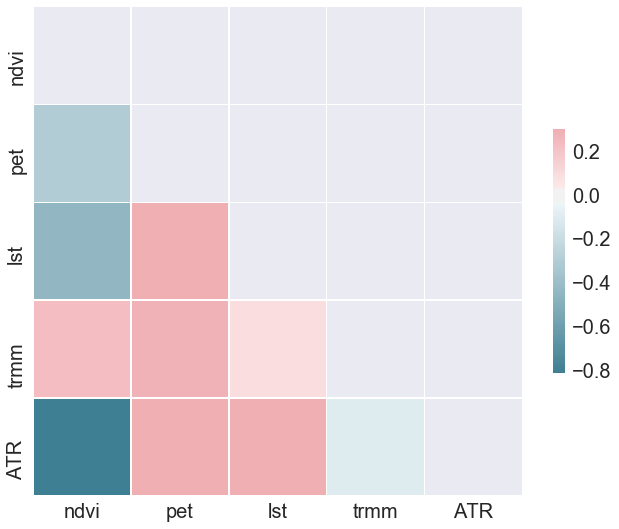

In [227]:

corr = df_tog[['ndvi','pet','lst', 'trmm','ATR']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=2) 
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

* Intuitively, NDVI is positively correlated with precipitation and negatively correlated with LST and PET.
* Also, PET, as a modeled product with temperature and precipitation as major inputs, is positively correlated with LST and TRMM.
* Temperature appears to be mildly positively correlated with precipitation, which is because the dry season corresponds to the winter or colder season in the southern atmosphere, or Sao Paulo here.

### Cluster the points to find a refined cutting point of the Day of Year of periods
* The previous scatter plots between ATR and weather variables manifested three clusters of DOY periods
* Because of such differing responses of ATR to weather conditions at different time of the year, it would be more accurately to model those three periods separately
* First of all, we need to clearly define the boundaries of those three clusters, and KMeans is a simple clustering method to do so

In [288]:

X = np.array(df_tog[['ndvi','pet','lst', 'trmm','ATR','DOY']].dropna())
f_names = ['ndvi','pet','lst', 'trmm','ATR','DOY']
kmeans = KMeans(3)
kmeans.fit(X)
# save new clusters for chart
y_km = kmeans.fit_predict(X)

* Add a variable name `group` to record the KMeans clustering result, as printed below

In [249]:
data_decision = pd.DataFrame(X)
data_decision.columns = f_names
data_decision['group'] = y_km
data_decision.head()

,ndvi,pet,lst,trmm,ATR,DOY,group
0,0.71558,3.29436,25.3096,12.1327,87.8972,106,0
1,0.71558,3.29436,25.3096,12.1327,87.8972,106,0
2,0.71558,3.29436,25.3096,12.1327,87.8972,106,0
3,0.71558,3.29436,25.3096,12.1327,87.8972,106,0
4,0.71558,3.29436,25.3096,12.1327,87.8972,106,0


In [250]:
print(data_decision.groupby('group').min())
data_decision.groupby('group').max()

           ndvi       pet        lst      trmm         ATR  DOY
group                                                          
0      0.580872  1.544240  19.164008  0.039923   80.231441  106
1      0.426879  3.082981  25.771094  0.399399  104.807083  273
2      0.450034  1.731405  19.779119  0.012298  111.547468  196


,ndvi,pet,lst,trmm,ATR,DOY
group,,,,,,
0,0.715580,4.558520,30.300360,12.132686,129.110569,182
1,0.697306,5.452482,33.526674,14.202166,156.861358,335
2,0.650728,5.621423,31.948077,8.184012,145.340109,259


We see that the three clusters of periods are the following
* period DOY 100-182
* period DOY 196-259
* period DOY 273-350

Cutoff DOY between periods: 190, 265.
Next, we visualize the relationship between all combinations of variables colored by the clustering groups

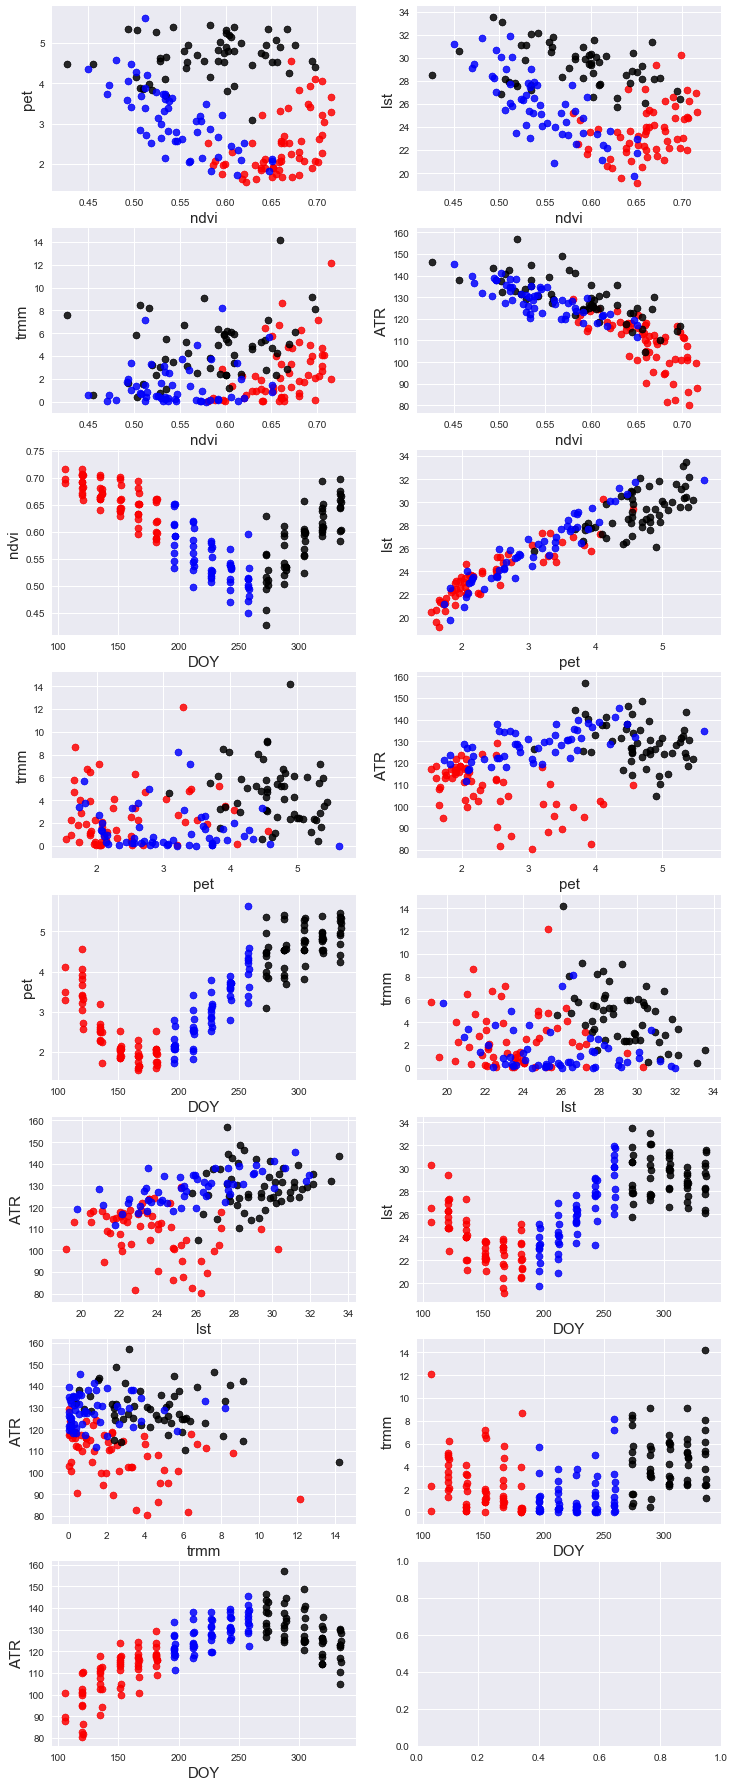

In [254]:
combos = [l for l in itertools.combinations(f_names,2)]

n_vars = len(combos)
n_rows = n_vars//2 + n_vars%2
sns.set(font_scale=1) 
alpha = 0.2
fig, axes = plt.subplots(n_rows, 2, figsize=(12, n_rows*4))
for i in range(n_vars):
    ax = axes[i//2, i % 2]
    var_1, var2 = combos[i]
    if 'DOY' in combos[i]:
        var_1 = 'DOY'
        var2 = (set(combos[i]) - {'DOY'}).pop()
    ax.scatter(X[y_km ==0,f_names.index(var_1)], X[y_km == 0,f_names.index(var2)], s=50, c='red', alpha = alpha)
    ax.scatter(X[y_km ==1,f_names.index(var_1)], X[y_km == 1,f_names.index(var2)], s=50, c='black', alpha = alpha)
    ax.scatter(X[y_km ==2,f_names.index(var_1)], X[y_km == 2,f_names.index(var2)], s=50, c='blue', alpha = alpha)
    ax.set_xlabel(var_1, fontsize=15)
    ax.set_ylabel(var2, fontsize=15)

* The red color is the earliest group, the blue color shows the middle group and the black color represents the latest group above.
* The seansonality is also clearly portrayed by the Temperature, precipitation and PET from the DOY 100 to 350

### Fit a multivariate linear regression for each Sub-harvesting-season

In [337]:
for name in ['lst','pet','trmm','ndvi','intercept', 'ATR']:
    df_tog[name] = df_tog[name].astype(float)

In [275]:
new_dat_list = []    
ranges = [(100, 190), (190, 265), (265,350)]
for L, R in ranges:
    sub_dat = df_tog[df_tog['DOY'] > L][df_tog['DOY'] < R].dropna()
    sub_dat['intercept'] = 1.
    X = sub_dat[['lst','pet','trmm','ndvi','intercept']]
    Y = sub_dat['ATR']
    # with statsmodels
    model = sm.OLS(Y, X).fit()
    sub_dat['pred'] = model.predict(X) 
    new_dat_list.append(sub_dat)
    
    print_model = model.summary()
    print(data_decision[data_decision['group']==g]['DOY'].dropna().max())
    print(print_model)
with_pred = pd.concat(new_dat_list, axis=0)#.drop_duplicates()


182
                            OLS Regression Results                            
Dep. Variable:                    ATR   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     149.4
Date:                Wed, 15 May 2019   Prob (F-statistic):           3.76e-82
Time:                        15:28:52   Log-Likelihood:                -1624.9
No. Observations:                 472   AIC:                             3260.
Df Residuals:                     467   BIC:                             3281.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ndvi        -146.6309     13.144    -11.155     

* The middle period linear regression model (DOY 196-259) appeared to have the best performance in terms of the variance explained
* The following scatter plot shows the predicted versus actual yield along the 1-1 line

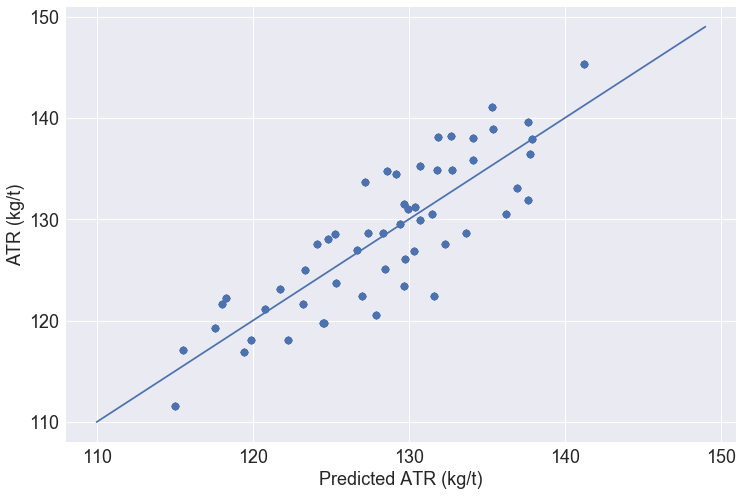

In [350]:
sns.set(font_scale=2.5) 
fig, ax = plt.subplots(figsize=(12,8))
with_pred[(df_tog['DOY'] > 190) & (df_tog['DOY'] < 265)].plot(x='pred', y='ATR', fontsize=18, kind='scatter', legend=False, ax=ax, s=50)
ax.plot(range(110,150), range(110,150))
plt.xlabel('Predicted ATR (kg/t)', fontsize=18)
plt.ylabel('ATR (kg/t)', fontsize=18)
plt.show()

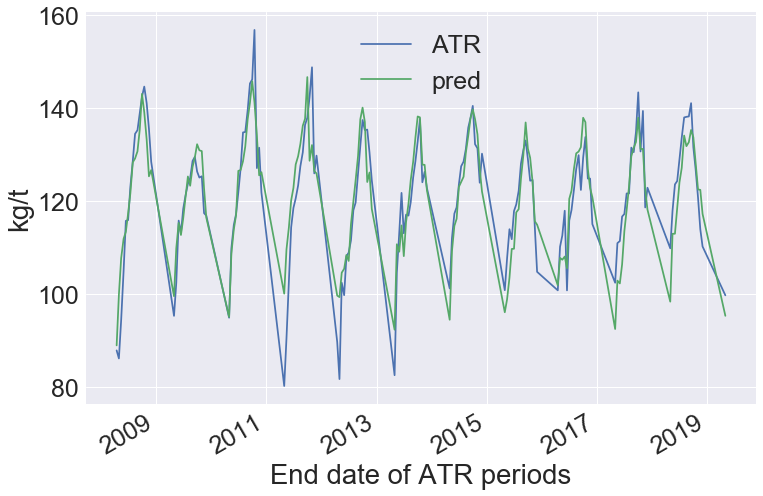

In [375]:
with_pred.set_index('end_date')

fig, ax = plt.subplots(figsize=(12,8))
with_pred.plot(x='end_date', y='ATR', ax=ax)
with_pred.plot(x='end_date', y='pred', ax=ax)
plt.xlabel('End date of ATR periods')
plt.ylabel('kg/t')
plt.show()

* Our model estimated ATR of all periods combined matched well with the Actual, especially during the peak ATR value periods

### Making predictions with the Model coefficients when a most recent period of ATR value was assumed to be available

In [148]:
# the cluster of ATR periods DOY 100-182
coef_early = {'ndvi'  :      -146.6309   ,  
                'pet'  :       -10.4294  ,   
                'lst'  :         2.2627  ,   
                'trmm'  :        -0.6265 }


# the cluster of DOY periods 196-259
coef_mid = {
'ndvi':   -108.6083,  
'pet':     -1.5546,      
'lst':      0.9189,      
'trmm':      0.8617,  
}

# the cluster of ATR periods DOY 273-350
coef_late = {
'ndvi'  ,      -108.3733,
'pet'    ,      -5.0304,
'lst'    ,       0.1131,
'trmm'   ,       -0.5143  }

In [300]:
recent_df = df_tog.sort_values(['year','DOY']).tail()

recent_diff = recent_df[coef_early.keys()].diff()

recent_df['ATR_diff'] = np.dot(recent_diff.values, np.array(coef_early.values()
                                                                     ).reshape(4, -1)).reshape(1,-1)[0]

recent_df['pred_ATR'] = [np.nan] + list(recent_df['ATR_diff'].values[1:] + recent_df['ATR'].values[:-1])

In [301]:
recent_df

,end_date,region_id,ndvi,doy,year,DOY,Year,pet,ATR,trmm,lst,ATR_diff,pred_ATR
185,2019-04-30 00:00:00+00:00,10408,0.715064,120,2019,120,2019,3.650152,99.754063,0.777547,27.483701,NaN,NaN
186,2019-05-15 00:00:00+00:00,10408,0.714196,135,2019,135,2019,2.991520,108.653547,2.659477,25.375579,1.047326,100.801389
187,2019-05-31 00:00:00+00:00,10408,0.695092,151,2019,151,2019,2.539245,114.160160,2.796357,24.552704,5.570481,114.224028
188,2019-06-15 00:00:00+00:00,10408,0.670779,166,2019,166,2019,2.442303,117.480458,1.293619,23.721730,3.637391,117.797551
189,2019-06-30 00:00:00+00:00,10408,0.637306,181,2019,181,2019,2.680475,122.388328,0.155427,25.639388,7.476301,124.956758
